Isotropic Total Variation (Accelerated PGM)
===========================================

This example demonstrates the use of class
[pgm.AcceleratedPGM](../_autosummary/scico.pgm.rst#scico.pgm.AcceleratedPGM)
to solve isotropic total variation (TV) regularization. It solves the
denoising problem

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - \mathbf{x}
  \|^2 + \lambda R(\mathbf{x}) + \iota_C(\mathbf{x}) \;,$$

where $R$ is a TV regularizer, $\iota_C(\cdot)$ is the indicator function
of constraint set $C$, and $C = \{ \mathbf{x} \, | \, x_i \in [0, 1] \}$,
i.e. the set of vectors with components constrained to be in the interval
$[0, 1]$. The problem is solved seperately with $R$ taken as isotropic
and anisotropic TV regularization

The solution via PGM is based on the approach in <cite data-cite="beck-2009-tv"/>,
which involves constructing a dual for the constrained denoising problem.
The PGM solution minimizes the resulting dual. In this case, switching
between the two regularizers corresponds to switching between two
different projectors.

In [1]:
from typing import Callable, Optional, Union

import jax
import jax.numpy as jnp

from xdesign import SiemensStar, discrete_phantom

import scico.numpy as snp
import scico.random
from scico import functional, linop, loss, operator, plot
from scico.blockarray import BlockArray
from scico.pgm import AcceleratedPGM, RobustLineSearchStepSize
from scico.typing import JaxArray
from scico.util import device_info, ensure_on_device
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
N = 256  # image size
phantom = SiemensStar(16)
x_gt = snp.pad(discrete_phantom(phantom, 240), 8)
x_gt = jax.device_put(x_gt)  # convert to jax type, push to GPU
x_gt = x_gt / x_gt.max()

Add noise to create a noisy test image.

In [3]:
σ = 0.75  # noise standard deviation
noise, key = scico.random.randn(x_gt.shape, seed=0)
y = x_gt + σ * noise

Define finite difference operator and adjoint.

In [4]:
# The append=0 option appends 0 to the input along the axis
# prior to performing the difference to make the results of
# horizontal and vertical finite differences the same shape
C = linop.FiniteDifference(input_shape=x_gt.shape, append=0)
A = C.adj

Define a zero array as initial estimate.

In [5]:
x0 = jnp.zeros(C(y).shape)

Define the dual of the total variation denoising problem.

In [6]:
class DualTVLoss(loss.Loss):
    def __init__(
        self,
        y: Union[JaxArray, BlockArray],
        A: Optional[Union[Callable, operator.Operator]] = None,
        lmbda: float = 0.5,
    ):
        y = ensure_on_device(y)
        self.functional = functional.SquaredL2Norm()
        super().__init__(y=y, A=A, scale=1.0)
        self.lmbda = lmbda

    def __call__(self, x: Union[JaxArray, BlockArray]) -> float:

        xint = self.y - self.lmbda * self.A(x)
        return -1.0 * self.functional(xint - jnp.clip(xint, 0.0, 1.0)) + self.functional(xint)

Denoise with isotropic total variation. Define projector for isotropic
total variation.

In [7]:
# Evaluation of functional set to zero.
class IsoProjector(functional.Functional):

    has_eval = True
    has_prox = True
    is_smooth = False

    def __call__(self, x: Union[JaxArray, BlockArray]) -> float:
        return 0.0

    def prox(self, x: JaxArray, lam: float, **kwargs) -> JaxArray:
        norm_x_ptp = jnp.sqrt(jnp.sum(jnp.abs(x) ** 2, axis=0))

        x_out = x / jnp.maximum(jnp.ones(x.shape), norm_x_ptp)
        out1 = x[0, :, -1] / jnp.maximum(jnp.ones(x[0, :, -1].shape), jnp.abs(x[0, :, -1]))
        x_out_1 = jax.ops.index_update(x_out, jax.ops.index[0, :, -1], out1)
        out2 = x[1, -1, :] / jnp.maximum(jnp.ones(x[1, -1, :].shape), jnp.abs(x[1, -1, :]))
        x_out = jax.ops.index_update(x_out_1, jax.ops.index[1, -1, :], out2)

        return x_out

Use RobustLineSearchStepSize object and set up AcceleratedPGM solver
object. Run the solver.

In [8]:
reg_weight_iso = 1.4e0
f_iso = DualTVLoss(y=y, A=A, lmbda=reg_weight_iso)
f_iso.is_smooth = True
g_iso = IsoProjector()

solver_iso = AcceleratedPGM(
    f=f_iso,
    g=g_iso,
    L0=16.0 * f_iso.lmbda ** 2,
    x0=x0,
    maxiter=100,
    verbose=True,
    step_size=RobustLineSearchStepSize(),
)

# Run the solver.
print(f"Solving on {device_info()}\n")
x = solver_iso.solve()
hist_iso = solver_iso.itstat_object.history(transpose=True)
# Project to constraint set.
x_iso = jnp.clip(y - f_iso.lmbda * f_iso.A(x), 0.0, 1.0)

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Objective  L         Residual
---------------------------------------------
   0  4.40e+00  3.122e+04  2.822e+01  1.826e+01
   1  4.50e+00  2.691e+04  2.540e+01  1.436e+01
   2  4.52e+00  2.426e+04  2.286e+01  1.315e+01
   3  4.55e+00  2.276e+04  2.058e+01  1.131e+01
   4  4.57e+00  2.179e+04  1.852e+01  1.017e+01
   5  4.60e+00  2.107e+04  1.667e+01  9.737e+00
   6  4.62e+00  2.051e+04  1.500e+01  9.852e+00
   7  4.67e+00  2.013e+04  2.700e+01  6.654e+00


   8  4.70e+00  1.980e+04  2.430e+01  6.860e+00
   9  4.72e+00  1.947e+04  2.187e+01  7.298e+00
  10  4.75e+00  1.915e+04  1.968e+01  7.745e+00
  11  4.79e+00  1.884e+04  1.771e+01  8.224e+00
  12  4.84e+00  1.864e+04  3.189e+01  5.799e+00
  13  4.87e+00  1.844e+04  2.870e+01  6.043e+00
  14  4.89e+00  1.825e+04  2.583e+01  6.297e+00


  15  4.92e+00  1.807e+04  2.324e+01  6.514e+00
  16  4.95e+00  1.791e+04  2.092e+01  6.678e+00
  17  4.97e+00  1.776e+04  1.883e+01  6.796e+00
  18  5.00e+00  1.762e+04  1.695e+01  6.865e+00
  19  5.03e+00  1.751e+04  1.525e+01  6.906e+00
  20  5.08e+00  1.743e+04  2.745e+01  4.781e+00
  21  5.11e+00  1.737e+04  2.471e+01  4.815e+00


  22  5.13e+00  1.731e+04  2.224e+01  4.868e+00
  23  5.17e+00  1.725e+04  2.001e+01  4.914e+00
  24  5.19e+00  1.720e+04  1.801e+01  4.958e+00
  25  5.25e+00  1.717e+04  3.242e+01  3.486e+00
  26  5.28e+00  1.714e+04  2.918e+01  3.556e+00
  27  5.30e+00  1.711e+04  2.626e+01  3.633e+00
  28  5.33e+00  1.708e+04  2.363e+01  3.703e+00


  29  5.36e+00  1.706e+04  2.127e+01  3.768e+00
  30  5.39e+00  1.703e+04  1.914e+01  3.830e+00
  31  5.42e+00  1.701e+04  1.723e+01  3.895e+00
  32  5.45e+00  1.699e+04  1.551e+01  3.960e+00
  33  5.50e+00  1.697e+04  2.791e+01  2.819e+00
  34  5.53e+00  1.696e+04  2.512e+01  2.891e+00
  35  5.56e+00  1.694e+04  2.261e+01  2.968e+00


  36  5.59e+00  1.693e+04  2.035e+01  3.041e+00
  37  5.62e+00  1.692e+04  1.831e+01  3.117e+00
  38  5.65e+00  1.691e+04  1.648e+01  3.200e+00
  39  5.70e+00  1.690e+04  2.967e+01  2.296e+00
  40  5.72e+00  1.689e+04  2.670e+01  2.355e+00
  41  5.75e+00  1.688e+04  2.403e+01  2.425e+00
  42  5.77e+00  1.687e+04  2.163e+01  2.498e+00


  43  5.80e+00  1.687e+04  1.946e+01  2.568e+00
  44  5.82e+00  1.686e+04  1.752e+01  2.644e+00
  45  5.87e+00  1.685e+04  3.153e+01  1.907e+00
  46  5.90e+00  1.685e+04  2.838e+01  1.969e+00
  47  5.93e+00  1.684e+04  2.554e+01  2.036e+00
  48  5.95e+00  1.684e+04  2.299e+01  2.103e+00
  49  5.98e+00  1.683e+04  2.069e+01  2.171e+00


  50  6.01e+00  1.683e+04  1.862e+01  2.238e+00
  51  6.03e+00  1.682e+04  1.676e+01  2.303e+00
  52  6.06e+00  1.682e+04  1.508e+01  2.376e+00
  53  6.10e+00  1.681e+04  2.715e+01  1.715e+00
  54  6.12e+00  1.681e+04  2.443e+01  1.765e+00
  55  6.14e+00  1.681e+04  2.199e+01  1.822e+00
  56  6.17e+00  1.681e+04  1.979e+01  1.882e+00


  57  6.22e+00  1.680e+04  3.562e+01  1.365e+00
  58  6.24e+00  1.680e+04  3.206e+01  1.416e+00
  59  6.27e+00  1.680e+04  2.885e+01  1.467e+00
  60  6.30e+00  1.680e+04  2.597e+01  1.520e+00
  61  6.32e+00  1.679e+04  2.337e+01  1.574e+00
  62  6.35e+00  1.679e+04  2.103e+01  1.632e+00
  63  6.37e+00  1.679e+04  1.893e+01  1.690e+00
  64  6.39e+00  1.679e+04  1.704e+01  1.751e+00


  65  6.42e+00  1.678e+04  1.533e+01  1.813e+00
  66  6.47e+00  1.678e+04  2.760e+01  1.319e+00
  67  6.49e+00  1.678e+04  2.484e+01  1.369e+00
  68  6.51e+00  1.678e+04  2.236e+01  1.424e+00
  69  6.53e+00  1.678e+04  2.012e+01  1.481e+00
  70  6.55e+00  1.678e+04  1.811e+01  1.541e+00
  71  6.60e+00  1.678e+04  3.260e+01  1.127e+00


  72  6.62e+00  1.677e+04  2.934e+01  1.175e+00
  73  6.65e+00  1.677e+04  2.640e+01  1.226e+00
  74  6.67e+00  1.677e+04  2.376e+01  1.278e+00
  75  6.69e+00  1.677e+04  2.139e+01  1.328e+00
  76  6.72e+00  1.677e+04  1.925e+01  1.380e+00
  77  6.74e+00  1.677e+04  1.732e+01  1.436e+00
  78  6.77e+00  1.677e+04  1.559e+01  1.495e+00
  79  6.81e+00  1.676e+04  2.806e+01  1.093e+00


  80  6.84e+00  1.676e+04  2.526e+01  1.138e+00
  81  6.86e+00  1.676e+04  2.273e+01  1.186e+00
  82  6.89e+00  1.676e+04  2.046e+01  1.235e+00
  83  6.91e+00  1.676e+04  1.841e+01  1.286e+00
  84  6.93e+00  1.676e+04  1.657e+01  1.340e+00
  85  6.97e+00  1.676e+04  2.983e+01  9.819e-01
  86  7.01e+00  1.676e+04  2.685e+01  1.024e+00
  87  7.04e+00  1.676e+04  2.416e+01  1.070e+00


  88  7.06e+00  1.676e+04  2.174e+01  1.118e+00
  89  7.09e+00  1.676e+04  1.957e+01  1.167e+00
  90  7.12e+00  1.675e+04  1.761e+01  1.218e+00
  91  7.18e+00  1.675e+04  3.170e+01  8.945e-01
  92  7.20e+00  1.675e+04  2.853e+01  9.342e-01
  93  7.23e+00  1.675e+04  2.568e+01  9.759e-01


  94  7.25e+00  1.675e+04  2.311e+01  1.019e+00
  95  7.27e+00  1.675e+04  2.080e+01  1.065e+00
  96  7.30e+00  1.675e+04  1.872e+01  1.112e+00
  97  7.33e+00  1.675e+04  1.685e+01  1.160e+00
  98  7.35e+00  1.675e+04  1.516e+01  1.209e+00
  99  7.40e+00  1.675e+04  2.729e+01  8.876e-01


Denoise with anisotropic total variation for comparison. Define
projector for anisotropic total variation.

In [9]:
# Evaluation of functional set to zero.
class AnisoProjector(functional.Functional):

    has_eval = True
    has_prox = True
    is_smooth = False

    def __call__(self, x: Union[JaxArray, BlockArray]) -> float:
        return 0.0

    def prox(self, x: JaxArray, lam: float, **kwargs) -> JaxArray:

        return x / jnp.maximum(jnp.ones(x.shape), jnp.abs(x))

Use RobustLineSearchStepSize object and set up AcceleratedPGM solver
object. Weight was tuned to give the same data fidelty as the
isotropic case. Run the solver.

In [10]:
reg_weight_aniso = 1.2e0
f = DualTVLoss(y=y, A=A, lmbda=reg_weight_aniso)
f.is_smooth = True
g = AnisoProjector()

solver = AcceleratedPGM(
    f=f,
    g=g,
    L0=16.0 * f.lmbda ** 2,
    x0=x0,
    maxiter=100,
    verbose=True,
    step_size=RobustLineSearchStepSize(),
)

# Run the solver.
x = solver.solve()
# Project to constraint set.
x_aniso = jnp.clip(y - f.lmbda * f.A(x), 0.0, 1.0)

Iter  Time      Objective  L         Residual
---------------------------------------------
   0  4.81e-01  3.122e+04  2.074e+01  2.130e+01
   1  5.05e-01  2.691e+04  1.866e+01  1.675e+01
   2  5.29e-01  2.426e+04  1.680e+01  1.535e+01
   3  5.57e-01  2.276e+04  1.512e+01  1.319e+01
   4  5.83e-01  2.179e+04  1.360e+01  1.187e+01
   5  6.13e-01  2.107e+04  1.224e+01  1.135e+01
   6  6.36e-01  2.051e+04  1.102e+01  1.148e+01


   7  6.89e-01  2.014e+04  1.984e+01  7.736e+00
   8  7.13e-01  1.981e+04  1.785e+01  7.948e+00
   9  7.38e-01  1.948e+04  1.607e+01  8.435e+00
  10  7.64e-01  1.917e+04  1.446e+01  8.925e+00
  11  7.96e-01  1.888e+04  1.301e+01  9.425e+00
  12  8.63e-01  1.868e+04  2.343e+01  6.638e+00


  13  8.94e-01  1.849e+04  2.108e+01  6.932e+00
  14  9.26e-01  1.830e+04  1.897e+01  7.242e+00
  15  9.57e-01  1.813e+04  1.708e+01  7.516e+00
  16  9.81e-01  1.796e+04  1.537e+01  7.759e+00
  17  1.01e+00  1.781e+04  1.383e+01  7.954e+00
  18  1.03e+00  1.767e+04  1.245e+01  8.079e+00
  19  1.05e+00  1.755e+04  1.120e+01  8.187e+00


  20  1.10e+00  1.748e+04  2.017e+01  5.680e+00
  21  1.13e+00  1.741e+04  1.815e+01  5.731e+00
  22  1.16e+00  1.734e+04  1.634e+01  5.790e+00
  23  1.19e+00  1.729e+04  1.470e+01  5.825e+00
  24  1.22e+00  1.724e+04  1.323e+01  5.866e+00
  25  1.29e+00  1.720e+04  2.382e+01  4.120e+00


  26  1.32e+00  1.717e+04  2.144e+01  4.201e+00
  27  1.35e+00  1.714e+04  1.929e+01  4.286e+00
  28  1.38e+00  1.711e+04  1.736e+01  4.360e+00
  29  1.41e+00  1.709e+04  1.563e+01  4.423e+00
  30  1.43e+00  1.706e+04  1.406e+01  4.489e+00
  31  1.46e+00  1.704e+04  1.266e+01  4.555e+00
  32  1.49e+00  1.702e+04  1.139e+01  4.618e+00


  33  1.54e+00  1.700e+04  2.051e+01  3.276e+00
  34  1.56e+00  1.699e+04  1.846e+01  3.353e+00
  35  1.58e+00  1.698e+04  1.661e+01  3.447e+00
  36  1.61e+00  1.696e+04  1.495e+01  3.537e+00
  37  1.64e+00  1.695e+04  1.345e+01  3.626e+00
  38  1.66e+00  1.694e+04  1.211e+01  3.721e+00
  39  1.70e+00  1.693e+04  2.180e+01  2.669e+00
  40  1.72e+00  1.692e+04  1.962e+01  2.742e+00


  41  1.74e+00  1.691e+04  1.765e+01  2.830e+00
  42  1.76e+00  1.691e+04  1.589e+01  2.916e+00
  43  1.79e+00  1.690e+04  1.430e+01  3.000e+00
  44  1.81e+00  1.689e+04  1.287e+01  3.085e+00
  45  1.85e+00  1.688e+04  2.317e+01  2.221e+00
  46  1.87e+00  1.688e+04  2.085e+01  2.292e+00
  47  1.89e+00  1.687e+04  1.876e+01  2.368e+00
  48  1.91e+00  1.687e+04  1.689e+01  2.445e+00
  49  1.92e+00  1.686e+04  1.520e+01  2.523e+00


  50  1.95e+00  1.686e+04  1.368e+01  2.601e+00
  51  1.97e+00  1.686e+04  1.231e+01  2.675e+00
  52  2.00e+00  1.685e+04  1.108e+01  2.755e+00
  53  2.04e+00  1.685e+04  1.994e+01  1.990e+00
  54  2.06e+00  1.684e+04  1.795e+01  2.048e+00
  55  2.08e+00  1.684e+04  1.615e+01  2.113e+00
  56  2.10e+00  1.684e+04  1.454e+01  2.181e+00
  57  2.13e+00  1.684e+04  2.617e+01  1.580e+00


  58  2.15e+00  1.683e+04  2.355e+01  1.636e+00
  59  2.18e+00  1.683e+04  2.120e+01  1.696e+00
  60  2.20e+00  1.683e+04  1.908e+01  1.758e+00
  61  2.22e+00  1.683e+04  1.717e+01  1.823e+00
  62  2.25e+00  1.682e+04  1.545e+01  1.888e+00
  63  2.28e+00  1.682e+04  1.391e+01  1.955e+00
  64  2.30e+00  1.682e+04  1.252e+01  2.022e+00
  65  2.32e+00  1.682e+04  1.127e+01  2.088e+00


  66  2.37e+00  1.682e+04  2.028e+01  1.518e+00
  67  2.39e+00  1.681e+04  1.825e+01  1.574e+00
  68  2.41e+00  1.681e+04  1.643e+01  1.634e+00
  69  2.43e+00  1.681e+04  1.478e+01  1.695e+00
  70  2.47e+00  1.681e+04  1.330e+01  1.760e+00
  71  2.54e+00  1.681e+04  2.395e+01  1.284e+00
  72  2.57e+00  1.681e+04  2.155e+01  1.336e+00


  73  2.59e+00  1.681e+04  1.940e+01  1.392e+00
  74  2.62e+00  1.681e+04  1.746e+01  1.451e+00
  75  2.64e+00  1.680e+04  1.571e+01  1.510e+00
  76  2.66e+00  1.680e+04  1.414e+01  1.571e+00
  77  2.68e+00  1.680e+04  1.273e+01  1.634e+00
  78  2.71e+00  1.680e+04  1.145e+01  1.697e+00
  79  2.77e+00  1.680e+04  2.062e+01  1.239e+00


  80  2.80e+00  1.680e+04  1.856e+01  1.290e+00
  81  2.82e+00  1.680e+04  1.670e+01  1.345e+00
  82  2.84e+00  1.680e+04  1.503e+01  1.399e+00
  83  2.86e+00  1.680e+04  1.353e+01  1.455e+00
  84  2.88e+00  1.679e+04  1.217e+01  1.517e+00
  85  2.92e+00  1.679e+04  2.191e+01  1.111e+00
  86  2.94e+00  1.679e+04  1.972e+01  1.157e+00
  87  2.97e+00  1.679e+04  1.775e+01  1.207e+00
  88  2.99e+00  1.679e+04  1.598e+01  1.258e+00


  89  3.01e+00  1.679e+04  1.438e+01  1.311e+00
  90  3.03e+00  1.679e+04  1.294e+01  1.366e+00
  91  3.06e+00  1.679e+04  1.165e+01  1.423e+00
  92  3.10e+00  1.679e+04  2.096e+01  1.043e+00
  93  3.13e+00  1.679e+04  1.887e+01  1.085e+00
  94  3.15e+00  1.679e+04  1.698e+01  1.131e+00
  95  3.17e+00  1.679e+04  1.528e+01  1.180e+00
  96  3.19e+00  1.679e+04  1.375e+01  1.230e+00


  97  3.24e+00  1.679e+04  2.476e+01  9.026e-01
  98  3.26e+00  1.679e+04  2.228e+01  9.427e-01
  99  3.29e+00  1.678e+04  2.005e+01  9.858e-01


Compute the data fidelity.

In [11]:
df = hist_iso.Objective[-1]
print(f"Data fidelity for isotropic TV was {df:.2e}")
hist = solver.itstat_object.history(transpose=True)
df = hist.Objective[-1]
print(f"Data fidelity for anisotropic TV was {df:.2e}")

Data fidelity for isotropic TV was 1.67e+04
Data fidelity for anisotropic TV was 1.68e+04


Plot results.

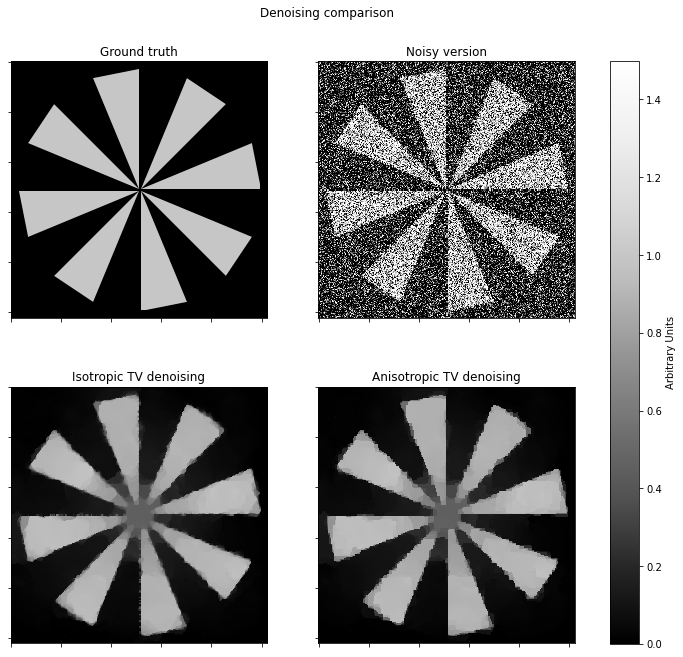

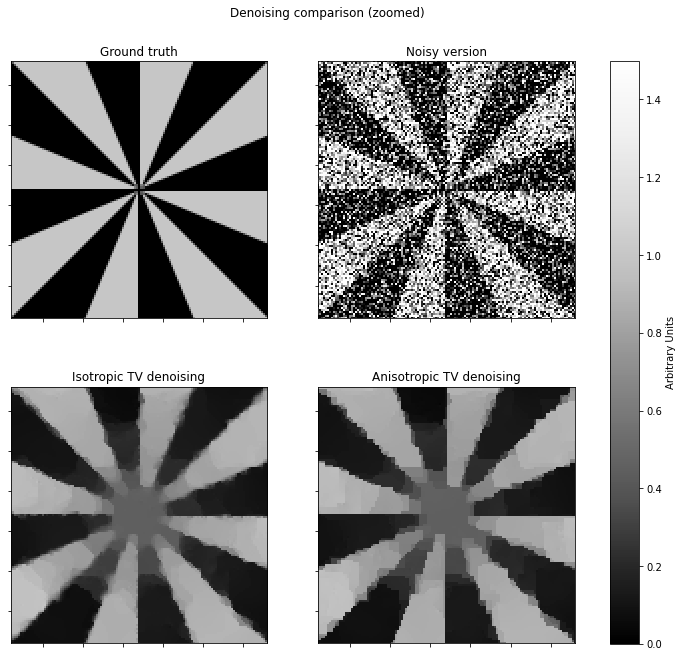

In [12]:
plt_args = dict(norm=plot.matplotlib.colors.Normalize(vmin=0, vmax=1.5))
fig, ax = plot.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(11, 10))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0, 0], **plt_args)
plot.imview(y, title="Noisy version", fig=fig, ax=ax[0, 1], **plt_args)
plot.imview(x_iso, title="Isotropic TV denoising", fig=fig, ax=ax[1, 0], **plt_args)
plot.imview(x_aniso, title="Anisotropic TV denoising", fig=fig, ax=ax[1, 1], **plt_args)
fig.subplots_adjust(left=0.1, right=0.99, top=0.95, bottom=0.05, wspace=0.2, hspace=0.01)
fig.colorbar(
    ax[0, 0].get_images()[0], ax=ax, location="right", shrink=0.9, pad=0.05, label="Arbitrary Units"
)
fig.suptitle("Denoising comparison")
fig.show()

# zoomed version
fig, ax = plot.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(11, 10))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0, 0], **plt_args)
plot.imview(y, title="Noisy version", fig=fig, ax=ax[0, 1], **plt_args)
plot.imview(x_iso, title="Isotropic TV denoising", fig=fig, ax=ax[1, 0], **plt_args)
plot.imview(x_aniso, title="Anisotropic TV denoising", fig=fig, ax=ax[1, 1], **plt_args)
ax[0, 0].set_xlim(N // 4, N // 4 + N // 2)
ax[0, 0].set_ylim(N // 4, N // 4 + N // 2)
fig.subplots_adjust(left=0.1, right=0.99, top=0.95, bottom=0.05, wspace=0.2, hspace=0.01)
fig.colorbar(
    ax[0, 0].get_images()[0], ax=ax, location="right", shrink=0.9, pad=0.05, label="Arbitrary Units"
)
fig.suptitle("Denoising comparison (zoomed)")
fig.show()